<a href="https://colab.research.google.com/github/visionNoob/Tensorflow_Tutorial/blob/master/Day_2/07-1%20-%20MNIST%20with%20DNN-eager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import train_test_split

import os
import time

tf.enable_eager_execution()
tf.set_random_seed(42)
tf.__version__

'1.14.0'

In [0]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape(-1, 784)
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape(-1, 784)
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

label = 3


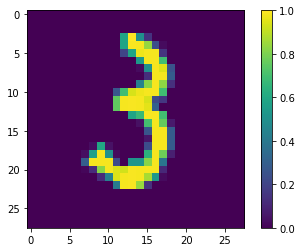

In [0]:
index = 1234
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index].reshape(28, 28))
plt.colorbar()
#plt.gca().grid(False)
plt.show()

In [0]:
def one_hot_label(image, label):
  label = tf.one_hot(label, depth=10)
  return image, label

In [0]:
batch_size = 512
max_epochs = 10

# for train
N = len(train_data)
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<DatasetV1Adapter shapes: ((?, 784), (?, 10)), types: (tf.float32, tf.float32)>
<DatasetV1Adapter shapes: ((?, 784), (?, 10)), types: (tf.float32, tf.float32)>


In [0]:
model = tf.keras.models.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(64, activation='relu'))
# Add another:
model.add(layers.Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(10, activation='softmax'))

In [0]:
# without training, just inference a model in eager execution:
predictions = model(train_data[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[0.08228894 0.09987275 0.08300041 0.1312486  0.09208547 0.09897505
  0.11530476 0.12539043 0.08465896 0.08717467]]


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  50240     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
acc_object = tf.keras.metrics.CategoricalAccuracy()

In [0]:
# use Adam optimizer
optimizer = tf.train.AdamOptimizer(1e-3)

mean_loss = tf.keras.metrics.Mean("loss")
mean_accuracy = tf.keras.metrics.Mean("accuracy")

loss_history = []
accuracy_history = [(0, 0.0)]

In [0]:
print("start training!")
global_step = tf.Variable(0, trainable=False)
num_batches_per_epoch = int(N/batch_size)

for epoch in range(max_epochs):
  for step, (images, labels) in enumerate(train_dataset):
    start_time = time.time()
    
    with tf.GradientTape() as tape:
      predictions = model(images, training=True)
      loss_value = loss_object(labels, predictions)
      acc_value = acc_object(labels, predictions)
      
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    global_step.assign_add(1)
    
    mean_loss(loss_value)
    mean_accuracy(acc_value)
    loss_history.append((global_step.numpy(), mean_loss.result().numpy()))
    
    if global_step.numpy() % 10 == 0:
      clear_output(wait=True)
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      print("epochs: {:.2f}, step: {}, loss: {:.3g}, accuracy: {:.4g}% ({:.2f} examples/sec; {:.4f} sec/batch)".format(
          epochs, global_step.numpy(), loss_value.numpy(), acc_value.numpy()*100, examples_per_sec, duration))
      
  # save mean accuracy for plot
  accuracy_history.append((global_step.numpy(), mean_accuracy.result().numpy()))
  
  # clear history
  mean_accuracy.reset_states()
  
print("training done!")

epochs: 10.00, step: 1180, loss: 0.187, accuracy: 83.55% (27244.03 examples/sec; 0.0188 sec/batch)
training done!


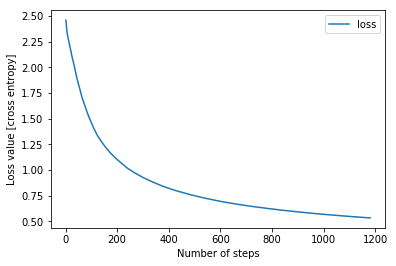

In [0]:
plt.plot(*zip(*loss_history), label='loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

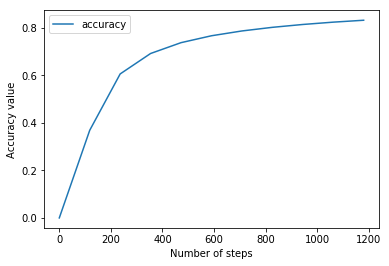

In [0]:
plt.plot(*zip(*accuracy_history), label='accuracy')
plt.xlabel('Number of steps')
plt.ylabel('Accuracy value')
plt.legend()
plt.show()

In [0]:
acc_object.reset_states()

for images, labels in test_dataset:
  predictions = model(images, training=False)
  acc_object(labels, predictions)
  
print("test accuracy: {:.4g}%".format(acc_object.result() * 100))

test accuracy: 95.06%


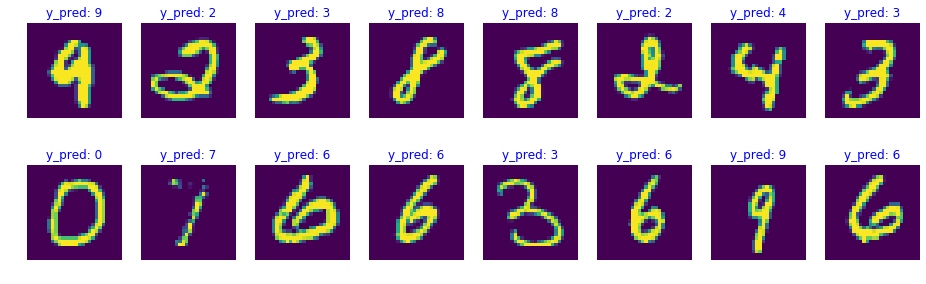

In [0]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')